In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import os
import pickle
import sys
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
        os.getcwd(),
        "data/nff",
        "offset_data.json",
    )

In [4]:
system_settings = {
    "surface_name": 'SrTiO3(001)',
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True
}

sampling_settings = {
    "alpha": 1.0, # no annealing
    "temperature": 1.0, # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "offset_data": json.load(open(offset_data_path, "r")),
    "optimizer": "BFGS",
    "relax_atoms": True,
    "relax_steps": 5,
    "offset": True,
}

Obtain adsorption sites

In [5]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
# new standardized params
# ads_positions = site_finder.find_adsorption_sites(
#     put_inside=True,
#     symm_reduce=False,
#     near_reduce=system_settings['near_reduce'],
#     distance=system_settings["planar_distance"],
#     no_obtuse_hollow=system_settings['no_obtuse_hollow'],
# )["all"]

# old params
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites["all"]

print("adsorption coordinates are")
print(ads_positions)

sweep_size = len(ads_positions)

adsorption coordinates are
[array([-0.   , -0.029, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([-0.   ,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829]), array([ 1.968,  4.131, 18.782]), array([ 3.936, -0.029, 18.87 ]), array([ 5.903,  1.951, 18.829]), array([ 5.903,  0.146, 18.782]), array([ 3.936,  3.956, 18.87 ]), array([ 5.903,  5.936, 18.829]), array([ 5.903,  4.131, 18.782]), array([ 9.839, 30.936, 18.806]), array([ 8.855, 30.848, 18.85 ]), array([29.517, 30.936, 18.806]), array([30.5  , 30.848, 18.85 ]), array([14.758, 15.998, 18.826]), array([15.742, 13.906, 18.829]), array([30.5  , 28.856, 18.85 ]), array([ 8.855, 28.856, 18.85 ]), array([10.823, 30.848, 18.85 ]), array([14.758, 24.871, 18.85 ]), array([16.726, 24.871, 18.85 ]), array([15.742, 25.861, 18.829]), array([30.5  , 27.953, 18.826]), array([29.517, 28.943, 18.806]), array([28.533, 28.856, 18.85 ]), array([28.533, 27.953, 18.826]), array([12.79 , 15.998, 18.826]), array([12.79 , 

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [6]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [7]:
# set attributes
slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=system_settings["cutoff"],
    props={"energy": 0, "energy_grad": []},
    calculator=nff_surf_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

surface = SurfaceSystem(slab_batch, ads_positions, nff_surf_calc, system_settings=system_settings)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
ads coords is [-0.    -0.029 18.87 ]
ads coords is [ 1.968  1.951 18.829]
ads coords is [ 1.968  0.146 18.782]
ads coords is [-0.     3.956 18.87 ]
ads coords is [ 1.968  5.936 18.829]
ads coords is [ 1.968  4.131 18.782]
ads coords is [ 3.936 -0.029 18.87 ]
ads coords is [ 5.903  1.951 18.829]
ads coords is [ 5.903  0.146 18.782]
ads coords is [ 3.936  3.956 18.87 ]
ads coords is [ 5.903  5.936 18.829]
ads coords is [ 5.903  4.131 18.782]
ads coords is [ 9.839 30.936 18.806]
ads coords is [ 8.855 30.848 18.85 ]
ads coords is [29.517 30.936 18.806]
ads 

2024-02-13 10:15:27,220|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-02-13 10:15:27,220|INFO|number of pristine atoms is 60
2024-02-13 10:15:27,221|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2024-02-13 10:15:27,221|INFO|surface indices are []


In [8]:
surface.get_potential_energy()

array([-467.541], dtype=float32)

In [9]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [10]:
from mcmc.energy import slab_energy
slab_energy(surface, offset=True, offset_data=calc_settings["offset_data"])

      Step     Time          Energy         fmax
BFGS:    0 10:15:27     -467.521851        0.0000


(12.49005126953125, 0.30546674132347107, 0.0, 0.0, [])

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-02-13 10:15:27,527|INFO|there are 60 atoms in pristine slab
2024-02-13 10:15:27,529|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-02-13 10:15:27,529|INFO|In pristine slab, there are a total of 72 sites


      Step     Time          Energy         fmax
BFGS:    0 10:15:27     -467.521851        0.0000


2024-02-13 10:15:27,648|INFO|running for 5 iterations per run over a total of 10 runs
2024-02-13 10:15:27,649|INFO|starting with iteration 0
2024-02-13 10:15:27,650|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 10:15:27     -461.974609       35.5128
BFGS:    1 10:15:27     -466.454254       13.0050
BFGS:    2 10:15:27     -467.626465        7.6705
BFGS:    3 10:15:27     -468.478180        2.8227
BFGS:    4 10:15:27     -468.660400        1.0193
BFGS:    5 10:15:27     -468.694092        0.3091
      Step     Time          Energy         fmax
BFGS:    0 10:15:28     -470.895599        7.5525
BFGS:    1 10:15:28     -471.568848        4.9533
BFGS:    2 10:15:28     -472.214844        2.8659
BFGS:    3 10:15:28     -472.706024        2.5436
BFGS:    4 10:15:28     -473.020905        2.5630
BFGS:    5 10:15:28     -473.241577        2.5334
      Step     Time          Energy         fmax
BFGS:    0 10:15:28     -469.791748        1.2914
BFGS:    1 10:15:28     -469.815582        1.2896
BFGS:    2 10:15:28     -470.066864        1.1935
BFGS:    3 10:15:28     -470.221344        0.8228
BFGS:  

2024-02-13 10:15:29,946|INFO|current energy is 14.610015869140625, calculated energy is 14.610015869140625
2024-02-13 10:15:29,947|INFO|optim structure has Energy = 14.610+/-0.266
2024-02-13 10:15:29,948|INFO|average force error = 0.000
2024-02-13 10:15:29,953|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:30     -474.554443        2.0132
BFGS:    1 10:15:30     -474.618561        1.9560
BFGS:    2 10:15:30     -475.000366        1.7036
BFGS:    3 10:15:30     -475.293976        2.1914
BFGS:    4 10:15:30     -475.658447        2.5817
BFGS:    5 10:15:30     -476.058197        2.4413
      Step     Time          Energy         fmax
BFGS:    0 10:15:30     -476.520782       13.5099
BFGS:    1 10:15:30     -479.422974        8.0712
BFGS:    2 10:15:30     -481.219818        4.6990
BFGS:    3 10:15:30     -482.341156        3.1731
BFGS:    4 10:15:30     -482.930817        2.5762
BFGS:    5 10:15:30     -483.184052        2.9055
      Step     Time          Energy         fmax
BFGS:    0 10:15:30     -472.595917       48.0067
BFGS:    1 10:15:30     -478.733765       12.1392
BFGS:    2 10:15:30     -480.224731        4.4444
BFGS:    3 10:15:30     -480.777191        2.7295
BFGS:    4 10:15:31     -481.302368        1.7909
BFG

2024-02-13 10:15:32,479|INFO|current energy is 11.832244873046875, calculated energy is 11.832244873046875
2024-02-13 10:15:32,480|INFO|optim structure has Energy = 11.832+/-0.150
2024-02-13 10:15:32,480|INFO|average force error = 0.000
2024-02-13 10:15:32,486|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:32     -475.817963       47.4846
BFGS:    1 10:15:32     -482.080414       11.8407
BFGS:    2 10:15:32     -484.066162        4.5891
BFGS:    3 10:15:32     -484.819794        2.6213
BFGS:    4 10:15:32     -485.358612        1.4479
BFGS:    5 10:15:32     -485.497467        0.8878
      Step     Time          Energy         fmax
BFGS:    0 10:15:33     -474.546631       47.5937
BFGS:    1 10:15:33     -480.413818       12.1004
BFGS:    2 10:15:33     -481.901459        4.5369
BFGS:    3 10:15:33     -482.486786        2.9804
BFGS:    4 10:15:33     -483.053375        1.5708
BFGS:    5 10:15:33     -483.234467        1.0911
      Step     Time          Energy         fmax
BFGS:    0 10:15:33     -467.530365       47.3006
BFGS:    1 10:15:33     -475.593842       15.8668
BFGS:    2 10:15:33     -479.307098        7.9232
BFGS:    3 10:15:33     -481.313934        5.0254
BFGS:    4 10:15:33     -482.493164        2.6830
BFG

2024-02-13 10:15:35,391|INFO|current energy is 13.82220458984375, calculated energy is 13.82220458984375
2024-02-13 10:15:35,391|INFO|optim structure has Energy = 13.822+/-0.064
2024-02-13 10:15:35,392|INFO|average force error = 0.000
2024-02-13 10:15:35,397|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:35     -459.356598       54.5747
BFGS:    1 10:15:35     -473.080353       17.2711
BFGS:    2 10:15:35     -478.569427       24.7094
BFGS:    3 10:15:35     -483.076813        8.1999
BFGS:    4 10:15:35     -485.345306        4.6560
BFGS:    5 10:15:35     -486.787994        3.3253
      Step     Time          Energy         fmax
BFGS:    0 10:15:36     -460.814362       53.0279
BFGS:    1 10:15:36     -475.050537       17.8629
BFGS:    2 10:15:36     -480.920898       24.0449
BFGS:    3 10:15:36     -485.348175        7.6884
BFGS:    4 10:15:36     -487.835541        4.6978
BFGS:    5 10:15:36     -489.462250        3.3679
      Step     Time          Energy         fmax
BFGS:    0 10:15:36     -421.465912      475.2883
BFGS:    1 10:15:36     -431.814178      287.5659
BFGS:    2 10:15:36     -454.464569       64.0953
BFGS:    3 10:15:36     -469.348236       23.5454
BFGS:    4 10:15:36     -479.124542       12.5558
BFG

2024-02-13 10:15:38,318|INFO|current energy is 13.816131591796875, calculated energy is 13.816131591796875
2024-02-13 10:15:38,319|INFO|optim structure has Energy = 13.816+/-0.076
2024-02-13 10:15:38,320|INFO|average force error = 0.000
2024-02-13 10:15:38,324|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:38    34295.683594   814628.1626
BFGS:    1 10:15:38     -429.796783      390.5867
BFGS:    2 10:15:38     -442.809174      375.7971
BFGS:    3 10:15:38     -452.084351      246.2129
BFGS:    4 10:15:38     -463.629059      137.9445
BFGS:    5 10:15:38     -467.517059       39.6494
      Step     Time          Energy         fmax
BFGS:    0 10:15:38     -441.178955       82.6512
BFGS:    1 10:15:38     -467.382812       34.9549
BFGS:    2 10:15:38     -478.748047       22.4692
BFGS:    3 10:15:38     -485.725006       12.3235
BFGS:    4 10:15:39     -489.749969        5.2240
BFGS:    5 10:15:39     -492.175140        4.9750
      Step     Time          Energy         fmax
BFGS:    0 10:15:39     -435.496674       59.7355
BFGS:    1 10:15:39     -464.428589       33.2580
BFGS:    2 10:15:39     -472.346588       28.8839
BFGS:    3 10:15:39     -481.933014       15.3218
BFGS:    4 10:15:39     -488.687592        9.8274
BFG

2024-02-13 10:15:40,699|INFO|current energy is 13.25823974609375, calculated energy is 13.25823974609375
2024-02-13 10:15:40,700|INFO|optim structure has Energy = 13.258+/-0.095
2024-02-13 10:15:40,700|INFO|average force error = 0.000
2024-02-13 10:15:40,704|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:40     -383.636139     1043.3426
BFGS:    1 10:15:40     -378.110107     1136.1149
BFGS:    2 10:15:40     -428.969086       83.1281
BFGS:    3 10:15:40     -456.950806       38.9808
BFGS:    4 10:15:40     -475.164642       20.3512
BFGS:    5 10:15:41     -484.075195       14.1089
      Step     Time          Energy         fmax
BFGS:    0 10:15:41     -441.654022       85.8593
BFGS:    1 10:15:41     -468.475952       33.6957
BFGS:    2 10:15:41     -481.263275       21.3877
BFGS:    3 10:15:41     -488.761261       14.4583
BFGS:    4 10:15:41     -493.528534        8.0397
BFGS:    5 10:15:41     -496.524902        5.6249
      Step     Time          Energy         fmax
BFGS:    0 10:15:41     1195.556152    29817.4177
BFGS:    1 10:15:41     -427.859375      109.1478
BFGS:    2 10:15:41     -454.822662      115.9142
BFGS:    3 10:15:41     -467.984253      102.2164
BFGS:    4 10:15:41     -475.613312      103.9645
BFG

2024-02-13 10:15:42,946|INFO|current energy is 12.55303955078125, calculated energy is 12.55303955078125
2024-02-13 10:15:42,947|INFO|optim structure has Energy = 12.553+/-0.137
2024-02-13 10:15:42,947|INFO|average force error = 0.000
2024-02-13 10:15:42,951|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:43     -424.702637       95.1189
BFGS:    1 10:15:43     -462.970795       42.4828
BFGS:    2 10:15:43     -479.441559       45.1565
BFGS:    3 10:15:43     -489.597565       15.6509
BFGS:    4 10:15:43     -495.910889       11.2796
BFGS:    5 10:15:43     -500.129883        7.6398
      Step     Time          Energy         fmax
BFGS:    0 10:15:43     1195.556274    29817.4177
BFGS:    1 10:15:43     -427.859375      109.1477
BFGS:    2 10:15:43     -454.822662      115.9142
BFGS:    3 10:15:43     -467.984222      102.2165
BFGS:    4 10:15:43     -475.613312      103.9652
BFGS:    5 10:15:43     -481.099121       67.8356
      Step     Time          Energy         fmax
BFGS:    0 10:15:43     -439.081665       85.8696
BFGS:    1 10:15:43     -465.749146       33.3697
BFGS:    2 10:15:43     -477.743561       23.5994
BFGS:    3 10:15:43     -486.477173       11.4619
BFGS:    4 10:15:43     -491.391815        7.9184
BFG

2024-02-13 10:15:45,267|INFO|current energy is 3.907684326171875, calculated energy is 3.907684326171875
2024-02-13 10:15:45,267|INFO|optim structure has Energy = 3.908+/-0.200
2024-02-13 10:15:45,268|INFO|average force error = 0.000
2024-02-13 10:15:45,274|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:45     -456.774414       86.7130
BFGS:    1 10:15:45     -484.348267       36.3190
BFGS:    2 10:15:45     -498.293060       24.7333
BFGS:    3 10:15:45     -507.327148       22.1685
BFGS:    4 10:15:45     -514.937744        7.5097
BFGS:    5 10:15:45     -519.169373        4.5712
      Step     Time          Energy         fmax
BFGS:    0 10:15:45     -402.168579      179.3464
BFGS:    1 10:15:45     -441.095215      228.5869
BFGS:    2 10:15:45     -457.336517       62.9474
BFGS:    3 10:15:45     -471.265533       70.4129
BFGS:    4 10:15:45     -480.848907       74.5535
BFGS:    5 10:15:46     -490.032135       51.3895
      Step     Time          Energy         fmax
BFGS:    0 10:15:46     -445.151001       85.5723
BFGS:    1 10:15:46     -472.879761       36.5706
BFGS:    2 10:15:46     -484.844574      143.0388
BFGS:    3 10:15:46     -497.162445       12.9585
BFGS:    4 10:15:46     -503.114471       16.8005
BFG

2024-02-13 10:15:47,696|INFO|current energy is 3.907684326171875, calculated energy is 3.907684326171875
2024-02-13 10:15:47,697|INFO|optim structure has Energy = 3.908+/-0.200
2024-02-13 10:15:47,697|INFO|average force error = 0.000
2024-02-13 10:15:47,702|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:47     -364.148773     1007.8039
BFGS:    1 10:15:47     -336.774811     1181.1754
BFGS:    2 10:15:47     -386.183350      142.4164
BFGS:    3 10:15:47     -428.715118       73.1538
BFGS:    4 10:15:47     -452.316559       64.2601
BFGS:    5 10:15:48     -474.384552       28.0779
      Step     Time          Energy         fmax
BFGS:    0 10:15:48     -428.269257       87.4739
BFGS:    1 10:15:48     -464.151825       33.3568
BFGS:    2 10:15:48     -478.513184       26.5673
BFGS:    3 10:15:48     -490.423248       13.7663
BFGS:    4 10:15:48     -496.978516        8.8930
BFGS:    5 10:15:48     -501.292969        6.1477
      Step     Time          Energy         fmax
BFGS:    0 10:15:48     -451.469604       86.6172
BFGS:    1 10:15:48     -481.124634       29.9842
BFGS:    2 10:15:48     -495.839020       21.8822
BFGS:    3 10:15:48     -505.897858       11.6909
BFGS:    4 10:15:48     -511.722015        8.0708
BFG

2024-02-13 10:15:50,158|INFO|current energy is 3.907684326171875, calculated energy is 3.907684326171875
2024-02-13 10:15:50,158|INFO|optim structure has Energy = 3.908+/-0.200
2024-02-13 10:15:50,159|INFO|average force error = 0.000
2024-02-13 10:15:50,165|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:50      102.467247     9057.5979
BFGS:    1 10:15:50     -419.169525       84.7395
BFGS:    2 10:15:50     -450.136230       70.3260
BFGS:    3 10:15:50     -469.993164       67.0528
BFGS:    4 10:15:50     -481.830078       65.8088
BFGS:    5 10:15:50     -489.259430       66.3274
      Step     Time          Energy         fmax
BFGS:    0 10:15:50     -433.603180      145.6311
BFGS:    1 10:15:50     -467.005035       48.5053
BFGS:    2 10:15:50     -481.084229       47.3107
BFGS:    3 10:15:50     -493.563141       46.0231
BFGS:    4 10:15:50     -503.261597       22.9063
BFGS:    5 10:15:50     -509.295074       13.3095
      Step     Time          Energy         fmax
BFGS:    0 10:15:51     -459.808838       86.7918
BFGS:    1 10:15:51     -487.126678       34.6233
BFGS:    2 10:15:51     -500.600250       24.9200
BFGS:    3 10:15:51     -510.964081       12.4054
BFGS:    4 10:15:51     -516.664856        7.7953
BFG

2024-02-13 10:15:52,618|INFO|current energy is 3.907684326171875, calculated energy is 3.907684326171875
2024-02-13 10:15:52,619|INFO|optim structure has Energy = 3.908+/-0.200
2024-02-13 10:15:52,620|INFO|average force error = 0.000


Time taken = 25.290269264020026 seconds


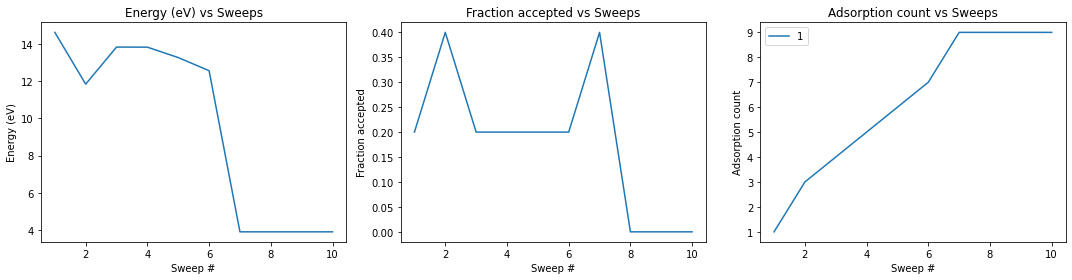

In [11]:
mcmc = MCMC(
    system_settings['surface_name'], 
    calc=nff_surf_calc, 
    canonical=False, 
    testing=False, 
    element=element, 
    adsorbates=list(calc_settings['chem_pots'].keys()), 
    relax=calc_settings['relax_atoms'], 
    relax_steps=calc_settings['relax_steps'],
    offset=calc_settings['offset'],
    offset_data=calc_settings['offset_data'],
    optimizer=calc_settings['optimizer']) # relax atoms with manual offset TODO fix this!

start = perf_counter()
# call the main function
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings['num_sweeps'],
    sweep_size=sampling_settings['sweep_size'],
    start_temp=sampling_settings['temperature'],
    pot=list(calc_settings['chem_pots'].values()),
    alpha=sampling_settings['alpha'],
    surface=surface
    )
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [12]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)